# 데이터 로딩 및 모델 선언

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow.keras import datasets, layers

%matplotlib inline

mnist = datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data("mnist.npz")




input_shape = (28, 28, 1) #input으로 들어갈 크기 지정
num_classes = 10 #클래스 개수


#---------Feature Extraction----------#

inputs = layers.Input(shape=input_shape)

net = layers.Conv2D(32, 3, padding='SAME')(inputs) # 아깐 layer(input) 이런식으로 넣었는데 이렇게 한번에 넣을수있음
net = layers.Activation('relu')(net)

net = layers.Conv2D(32, 3, padding='SAME')(net)
net = layers.Activation('relu')(net)

net = layers.MaxPool2D((2,2))(net) # 풀링

net = layers.Dropout(0.25)(net) # 드랍아웃


net = layers.Conv2D(64, 3, padding='SAME')(net)
net = layers.Activation('relu')(net)

net = layers.Conv2D(64, 3, padding='SAME')(net)
net = layers.Activation('relu')(net)

net = layers.MaxPool2D((2,2))(net)

net = layers.Dropout(0.25)(net)

#------------Fully Connected-------------#


net = layers.Flatten()(net) # [1, 3920] 꼴로 펴기
net = layers.Dense(512)(net)
net = layers.Activation('relu')(net)
net = layers.Dropout(0.25)(net)

net = layers.Dense(num_classes)(net) # 마지막에 내보내는 노드의 갯수는 총 10개. (결과의 결과)

net = layers.Activation('softmax')(net) # 최종적으로 들어오는 수치들을 0~1 사이의 값으로 만들어줌

model = tf.keras.Model(inputs = inputs, outputs = net, name = 'Basic_CNN')


#-------------------------------------#

x_train = x_train.reshape(60000, 28, 28, 1)
x_test = x_test.reshape(10000, 28, 28, 1)

x_train, x_test = x_train / 255., x_test / 255.

# tf.data 활용

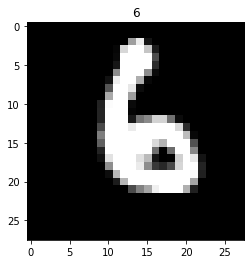

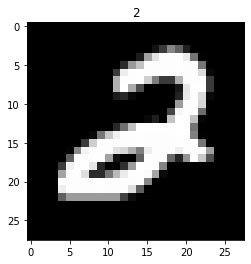

In [3]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)) #이제 한 쌍 단위로 나옴
train_ds = train_ds.shuffle(1000) # 버퍼 사이즈
train_ds = train_ds.batch(32) # iteration 할때마다 32쌍이 나오게 됨

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.batch(32)

# Visualize Data

for image, label in train_ds.take(2): # 전체를 돌리면 개많이 돌아가기때문에 take함수로 32쌍씩 2번 받아오기로함
    plt.title(f'{label[0]}') # 32쌍중 첫번째 라벨만
    plt.imshow(image[0, :, :, 0], 'gray') # 이것도 (32, 28, 28, 1)에서 첫번째것만
    plt.show()

In [6]:
# Optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy() # 오차 계산 함수

train_loss = tf.keras.metrics.Mean(name='train_loss') #loss율을 그대로 보여주기보단, 배치의 평균을 내서 부드럽게 출력하기
test_loss = tf.keras.metrics.Mean(name='test_loss')

train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name = 'train_accuracy') # 평가할 함수
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name = 'test_accuracy')

optimizer = tf.keras.optimizers.Adam() # 오차를 최소화하기 위한 optimizer Adam

'''
#Training
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
model.fit(train_ds, epochs = 10000) # 기존에는 (train_x train_y)를 넣었는데 이젠 한쌍으로 만든 train_ds 만 넣어주면 됨
'''

# Training
@tf.function    #선언하면 빨라진대
def train_step(images, labels):
    with tf.GradientTape() as tape: # 기울기 받는 함수를 tape로 인스턴스화
        predictions = model(images) # 예측값 얻기
        loss = loss_object(labels, predictions) # 오차 계산

    gradients = tape.gradient(loss, model.trainable_variables) # 기울기를 얻어와서
    optimizer.apply_gradients(zip(gradients, model.trainable_variables)) # Adam Optimizer에 대입하여 변경값얻을예정 // 2차함수 생각

    train_loss(loss) # loss의 평균을 내주는 함수에 loss 대입
    train_accuracy(labels, predictions)


@tf.function
def test_step(images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss) # 얘도 평균값 내주기
    test_accuracy(labels, predictions)

for epoch in range(2):
    for images, labels in train_ds:
        print(labels[0])
        train_step(images, labels)
    
    # 위 train for문이 다 돌면 아래 test가 돌아감
    for images, labels in test_ds:
        test_step(images, labels)

        # train을 test하는거 까지가 1 epoch

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss {}, Test Accuracy: {}'

    print(template.format(epoch+1, train_loss.result, train_accuracy.result() * 100,
                        test_loss.result(), test_accuracy.result() * 100))


Epoch 1, Loss: <bound method Metric.__new__.<locals>.result_fn of <tensorflow.python.keras.metrics.Mean object at 0x000001C298997908>>, Accuracy: 3.716780185699463, Test Loss 0.031198471784591675, Test Accuracy: 3.1248340606689453
Epoch 2, Loss: <bound method Metric.__new__.<locals>.result_fn of <tensorflow.python.keras.metrics.Mean object at 0x000001C298997908>>, Accuracy: 2.9998199939727783, Test Loss 0.03576616570353508, Test Accuracy: 3.582336664199829
